In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from utils import calcular_estatisticas, imprimir_estatisticas, rejeitar_hip_nula, do_cv, print_t_tests

In [2]:
df = pd.read_csv('arrhythmia.csv')
df.shape

(452, 280)

In [3]:
[(i, df[i].isnull().sum()) for i in df.columns if df[i].isnull().any()]

[('T', 8), ('P', 22), ('QRST', 1), ('J', 376), ('heartrate', 1)]

In [4]:
df.drop('J', axis=1, inplace=True)
df.shape

(452, 279)

In [5]:
X = df.drop('class', axis=1)
y = df['class'].values.ravel()
y-=1
y[y>0] = 1

In [6]:
np.unique(y, return_counts=True)

(array([0, 1]), array([245, 207]))

# Codificação de atributos nominais

In [7]:
#%timeit [i for i in df.columns if 'Exists' in i]

In [8]:
#%timeit list(filter(lambda x: 'Exists' in x, df.columns))

In [7]:
nominais = ['sex', *[i for i in df.columns if 'Exists' in i]]

In [9]:
transformers = [(i, OneHotEncoder(), [i]) for i in nominais]

ct = ColumnTransformer(transformers, remainder='passthrough', sparse_threshold=0)

In [10]:
X_ohoe = ct.fit_transform(X)


In [11]:
X_ohoe = pd.DataFrame(X_ohoe, columns=ct.get_feature_names())

In [12]:
X_ohoe

,sex__x0_0,sex__x0_1,chDI_RRwaveExists__x0_0,chDI_RRwaveExists__x0_1,chDI_DD_RRwaveExists__x0_0,chDI_DD_RRwaveExists__x0_1,chDI_RPwaveExists__x0_0,chDI_RPwaveExists__x0_1,chDI_DD_RPwaveExists__x0_0,chDI_DD_RPwaveExists__x0_1,...,chV6_JJwaveAmp,chV6_QwaveAmp,chV6_RwaveAmp,chV6_SwaveAmp,chV6_RPwaveAmp,chV6_SPwaveAmp,chV6_PwaveAmp,chV6_TwaveAmp,chV6_QRSA,chV6_QRSTA
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,4.3,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5
448,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.5,0.0,15.6,-1.6,0.0,0.0,0.4,2.4,38.0,62.4
449,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.2,0.0,16.3,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2
450,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.2,-0.4,12.0,-0.7,0.0,0.0,0.5,2.4,25.0,46.6


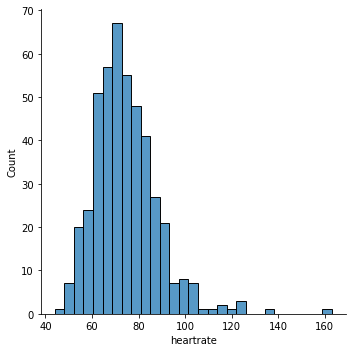

In [19]:
sns.displot(df['heartrate'])

In [20]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [15]:
#[('T', 8), ('P', 22), ('QRST', 1), ('J', 376), ('heartrate', 1)]

In [21]:
from sklearn.impute import SimpleImputer

transformers = [(col, SimpleImputer(strategy='median'), [col] ) for col in ['T', 'P', 'QRST', 'heartrate']]

ctimp = ColumnTransformer(transformers, remainder='passthrough', sparse_threshold=0)

In [22]:
f1_svm = do_cv(SVC, X_ohoe, y, 10, 10, 8, scale=True, imputer=ctimp, params={'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale']})
f1_knn = do_cv(KNeighborsClassifier, X_ohoe, y, 10, 10, 8, scale=True, imputer=ctimp, params={'n_neighbors' : range(1,30,2)})
f1_rf = do_cv(RandomForestClassifier, X_ohoe, y, 10, 10, 8, scale=False, imputer=ctimp, params={'criterion' : ['gini', 'entropy'], 'random_state' : [1]})

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
imprimir_estatisticas(f1_svm)
imprimir_estatisticas(f1_knn)
imprimir_estatisticas(f1_rf)
print(rejeitar_hip_nula(f1_svm, f1_knn))
print(rejeitar_hip_nula(f1_svm, f1_rf))

Resultados: 0.70 +- 0.11, min: 0.42, max: 0.85
Resultados: 0.47 +- 0.10, min: 0.30, max: 0.65
Resultados: 0.77 +- 0.09, min: 0.57, max: 0.87
(True, 0.00011872357864760984)
(False, 0.165654755212778)


# PCA para redução de dimensionalidade

<AxesSubplot:>

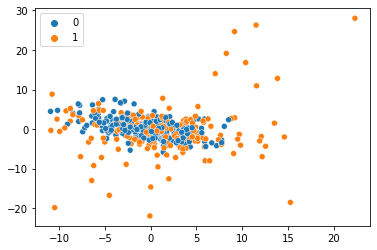

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_pca_imp = ctimp.fit_transform(X_ohoe)

ss_pca = StandardScaler()
X_pca_ss = ss_pca.fit_transform(X_pca_imp)

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_pca_ss)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)

In [25]:
resultados = {}

svm_teste = ('svm', SVC, True, {'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale']})
knn_teste = ('knn', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,2)})
rf_teste = ('rf', RandomForestClassifier, False, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})

testes = [svm_teste, knn_teste, rf_teste]

for nome, classificador, scale, params in testes:
    r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, None, params)
    resultados[nome] = r

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados)

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
        rf - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
       svm - Resultados: 0.71 +- 0.13, min: 0.38, max: 0.88

                knn          rf         svm     
    knn         1.00     0.00 (*<)   0.00 (*<)  
     rf      0.00 (*>)      1.00        0.33    
    svm      0.00 (*>)      0.33        1.00    


In [27]:
for nome, classificador, scale, params in testes:
    r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, PCA(n_components=8), params)
    nome = "%s_pca=08" % (nome)
    resultados[nome] = r

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados)

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_pca=08 - Resultados: 0.59 +- 0.08, min: 0.46, max: 0.74
        rf - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
 rf_pca=08 - Resultados: 0.64 +- 0.11, min: 0.48, max: 0.81
       svm - Resultados: 0.71 +- 0.13, min: 0.38, max: 0.88
svm_pca=08 - Resultados: 0.71 +- 0.07, min: 0.62, max: 0.85

                knn      knn_pca=08      rf      rf_pca=08      svm      svm_pca=08 
    knn         1.00     0.01 (*<)   0.00 (*<)   0.00 (*<)   0.00 (*<)   0.00 (*<)  
 knn_pca=08  0.01 (*>)      1.00     0.00 (*<)      0.19     0.02 (*<)   0.00 (*<)  
     rf      0.00 (*>)   0.00 (*>)      1.00     0.01 (*>)      0.33        0.19    
 rf_pca=08   0.00 (*>)      0.19     0.01 (*<)      1.00        0.26        0.12    
    svm      0.00 (*>)   0.02 (*>)      0.33        0.26        1.00        0.92    
 svm_pca=08  0.00 (*>)   0.00 (*>)      0.19        0.12        0.92        1.00    


In [29]:
for n_components in [16, 32, 64]:
    pca = PCA(n_components=n_components)
    for nome, classificador, scale, params in testes:
        r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, pca, params)
        nome = "%s_pca=%02d" % (nome, n_components)
        resultados[nome] = r

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, cols=['knn', 'rf', 'svm'])

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_pca=08 - Resultados: 0.59 +- 0.08, min: 0.46, max: 0.74
knn_pca=16 - Resultados: 0.55 +- 0.11, min: 0.37, max: 0.77
knn_pca=32 - Resultados: 0.57 +- 0.15, min: 0.29, max: 0.76
knn_pca=64 - Resultados: 0.55 +- 0.12, min: 0.39, max: 0.72
        rf - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
 rf_pca=08 - Resultados: 0.64 +- 0.11, min: 0.48, max: 0.81
 rf_pca=16 - Resultados: 0.66 +- 0.12, min: 0.47, max: 0.78
 rf_pca=32 - Resultados: 0.71 +- 0.09, min: 0.51, max: 0.84
 rf_pca=64 - Resultados: 0.72 +- 0.07, min: 0.60, max: 0.86
       svm - Resultados: 0.71 +- 0.13, min: 0.38, max: 0.88
svm_pca=08 - Resultados: 0.71 +- 0.07, min: 0.62, max: 0.85
svm_pca=16 - Resultados: 0.72 +- 0.11, min: 0.49, max: 0.90
svm_pca=32 - Resultados: 0.70 +- 0.09, min: 0.51, max: 0.86
svm_pca=64 - Resultados: 0.70 +- 0.08, min: 0.56, max: 0.84

                knn          rf         svm     
    knn         1.00     0.00 (*<)   0.00 (*<)  
 

# Projeções aleatórias

In [27]:
from sklearn.random_projection import GaussianRandomProjection

<AxesSubplot:>

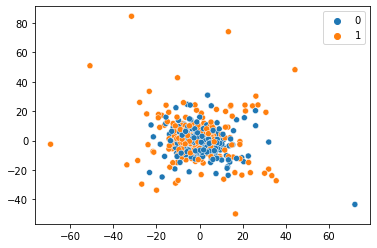

In [28]:
X_rp_imp = ctimp.fit_transform(X_ohoe)

ss_rp = StandardScaler()
X_rp_ss = ss_rp.fit_transform(X_rp_imp)

rp = GaussianRandomProjection(n_components=2)

X_rp = rp.fit_transform(X_rp_ss)

sns.scatterplot(x=X_rp[:,0], y=X_rp[:,1], hue=y)

In [29]:
for nome, classificador, scale, params in testes:
    r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, GaussianRandomProjection(n_components=8), params)
    nome = "%s_rp=08" % (nome)
    resultados[nome] = r

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, cols=['knn', 'rf', 'svm'])

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_pca=08 - Resultados: 0.59 +- 0.08, min: 0.46, max: 0.74
knn_pca=16 - Resultados: 0.55 +- 0.11, min: 0.37, max: 0.77
knn_pca=32 - Resultados: 0.57 +- 0.15, min: 0.29, max: 0.76
knn_pca=64 - Resultados: 0.55 +- 0.12, min: 0.39, max: 0.72
 knn_rp=08 - Resultados: 0.55 +- 0.09, min: 0.38, max: 0.65
        rf - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
 rf_pca=08 - Resultados: 0.64 +- 0.11, min: 0.48, max: 0.81
 rf_pca=16 - Resultados: 0.66 +- 0.12, min: 0.47, max: 0.78
 rf_pca=32 - Resultados: 0.71 +- 0.09, min: 0.51, max: 0.84
 rf_pca=64 - Resultados: 0.72 +- 0.07, min: 0.60, max: 0.86
  rf_rp=08 - Resultados: 0.58 +- 0.10, min: 0.36, max: 0.72
       svm - Resultados: 0.71 +- 0.13, min: 0.38, max: 0.88
svm_pca=08 - Resultados: 0.71 +- 0.07, min: 0.62, max: 0.85
svm_pca=16 - Resultados: 0.72 +- 0.11, min: 0.49, max: 0.90
svm_pca=32 - Resultados: 0.70 +- 0.09, min: 0.51, max: 0.86
svm_pca=64 - Resultados: 0.70 +- 0.08, m

In [31]:
for n_components in [16, 32, 64]:
    rp = GaussianRandomProjection(n_components=n_components)
    for nome, classificador, scale, params in testes:
        r = do_cv(classificador, X, y, 10, 10, 8, scale, ctimp, rp, params)
        nome = "%s_rp=%02d" % (nome, n_components)
        resultados[nome] = r

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, cols=['knn', 'rf', 'svm'])

       knn - Resultados: 0.48 +- 0.08, min: 0.36, max: 0.58
knn_pca=08 - Resultados: 0.59 +- 0.08, min: 0.46, max: 0.74
knn_pca=16 - Resultados: 0.55 +- 0.11, min: 0.37, max: 0.77
knn_pca=32 - Resultados: 0.57 +- 0.15, min: 0.29, max: 0.76
knn_pca=64 - Resultados: 0.55 +- 0.12, min: 0.39, max: 0.72
 knn_rp=08 - Resultados: 0.55 +- 0.09, min: 0.38, max: 0.65
 knn_rp=16 - Resultados: 0.53 +- 0.11, min: 0.36, max: 0.74
 knn_rp=32 - Resultados: 0.51 +- 0.12, min: 0.31, max: 0.69
 knn_rp=64 - Resultados: 0.51 +- 0.07, min: 0.40, max: 0.61
        rf - Resultados: 0.75 +- 0.07, min: 0.60, max: 0.86
 rf_pca=08 - Resultados: 0.64 +- 0.11, min: 0.48, max: 0.81
 rf_pca=16 - Resultados: 0.66 +- 0.12, min: 0.47, max: 0.78
 rf_pca=32 - Resultados: 0.71 +- 0.09, min: 0.51, max: 0.84
 rf_pca=64 - Resultados: 0.72 +- 0.07, min: 0.60, max: 0.86
  rf_rp=08 - Resultados: 0.58 +- 0.10, min: 0.36, max: 0.72
  rf_rp=16 - Resultados: 0.67 +- 0.09, min: 0.53, max: 0.82
  rf_rp=32 - Resultados: 0.63 +- 0.09, m